## Module 4: *(Template)*

**RENAME THE FILE TO INCLUDE YOUR COMPANY, GROUP NUMBER, AND LAST NAMES**

**E.G. KAMEN1_GROVES_MODULE_4.IPYNB**

## Team Members:
Jack O'Hearn, Vicente Carvajal Villegas

## Project Title:
Predicting future cases of Severe Acute Respiratory Syndrome in China in the early 2000's



## Project Goal:
This project seeks to take known data from the SARS outbreak in China from March 2003 to July 2003 and apply ordinary differential equations to predict future cases based on past trends.

## Disease Background:

Using your assigned disease, fill in the following bullet points. 

Prevalence & incidence

- Emerged in Guangdong Province, China in November 2002.
- The 2003/2002 Severe Acute Respirtory Syndrome (SARS) outbreak globally caused 8422 cases and 916 deaths. This is around a 11% fatality rate across 29 different countries.
- Specifically, China reported 5327 cases and 348 death between 2002-2003. Approximately 30 cases in CHina were heathcare workers. 

Economic burden

- In the 4 most affected East Asian countries, an estimated $13 billion of SARS-related GDP loss occured. This was driven by drops in travel, tourism, and hospitalityIn Beijing, an estimated $1.4 billion was lost from tourism.
- Other indirect costs occured as well, including business diruption, quartining, higher operating costs, stock market falls, and reduced trade.
- The economic cost in the medical field rose sharply due to isolation wards, personal protective equipment, emergency surveillance expansion, and hospital staffing strain spending.

Risk factors (genetic, lifestyle) & Societal determinants

- The population most at risk were those in and related to the health-care industry. Around 30% of cases came from medical staff not outfitted with proper protective equipment. 
- Older age, underlying conditions, and delayed hosptialization were associated with higher mortality and more severe cases.
- Fatality for those under the age of 24 was under 1%, but over 50% for individuals over 50. 
- Societal determinants included high population density (common in china), hospital crowding (intra-hospital transmission), and increased travel during Chinese New Year (Feburary 1, 2003).

Symptoms

- Common symptoms are high fever, chills, malaise, headache, dry cough, shortness of breath.
- In addition, diarrhea and vomiting were seen.
-Most patients developed pneumonia, and 10-20% reauired mechanical ventilation.

Diagnosis

- Diagnosis occured after a combination of symptoms and context. This included close contact with a SARC case or affected area, plus clinical findings of fever and evidence of pnemonia.
- Reverse-transcription PCR were detected to detect viral DNA, but versions at the time has limited detection/sensitivity in the onset of the illness.
- Chest radiography was also useful in diagnosis, as many patients developed patchy air spaces in the lungs around 7 day into the illness.  

Biological mechanisms (anatomy, organ physiology, cell & molecular physiology)

- SARS is caused by SARS-CoV, which is a single stranded RNA coronavirus that targets the respiratory tract, particularly the lower airways and alveoli.
- The viral spike from SARS binds the angiotensin-converting enzyme 2 (ACE2) receptor on respiratory endothelial cells, as well as type II pneumocytes allowing entry. ACE2 is expressed highly in lung and intestine tissues. 
- SARS-CoV infection and S binding downregulate ACE2, which disrupts its role in the renin-angiotensin system and causing pulmonary vasoconstriction and vascular permeability.
- SARS lungs typically display alveolar damage with hyaline membrane formation and intestitial inflammation. In some cases, also organizing fibrosis. These indicate a strong inflammitory response at the alveolar and capollary barrier.



## Dataset: 

The dataset used in this analysis is made of confirmed case counts from the 2003 Severe Acute Respiratory Syndrome (SARS-CoV) outbreak in mainland China and Hong Kong. The data originate from publicly available epidemiological reports compiled during the outbreak. Most SARS 2003 datasets were aggregated by international health agencies such as the World Health Organization (WHO), national Ministries of Health, and research groups that later digitized daily case totals for retrospective modeling studies.

**How the Data Was Collected**

Case counts during the 2003 SARS outbreak were collected through national and regional public-health surveillance systems. Surveillance teams used:
- Clinical case identification
- Laboratory confirmation
- Hospital and public-health reporting networks


**Variables**


The dataset includes two variables:

- date:
Calendar dates (YYYY-MM-DD format), representing each reporting day between March and July 2003.
Unit: timestamp (days)

- confirmed_cases:
Cumulative number of laboratory-confirmed SARS cases reported up to that date.
Unit: number of people (cases)

**Dataset Purpose**

This dataset is commonly used in epidemiology and infectious-disease modeling to:

- visualize the outbreak curve

- compute daily incidence

- fit SIR or SEIR compartmental models

- evaluate intervention timing (e.g., shutdown periods, quarantine enforcement)

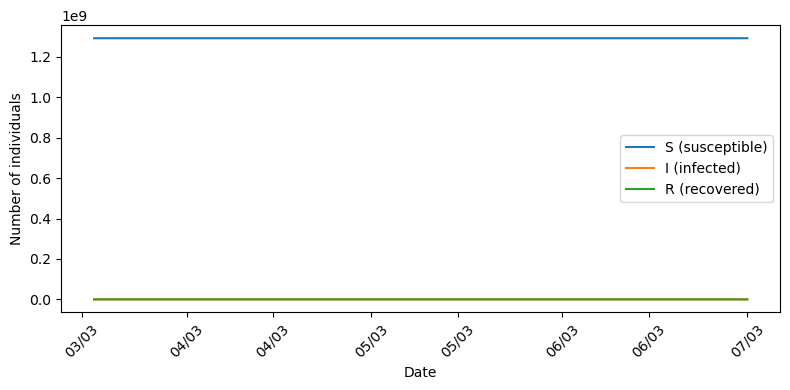

In [1]:
## LOAD YOUR DATASET HERE.

# 1. Read in the csv file of cumulative cases.

# 2. Use the convert_cumulative_to_SIR function to convert cumulative cases to approximate S, I, R at any given time.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from main_functions import convert_cumulative_to_SIR, euler_sir

# Total population 
N = 1_292_000_000 

# Read in csv file 
df = pd.read_csv("sars_china_hongkong_data_2003_cumulative.csv")

df_sir = convert_cumulative_to_SIR(
    df,
    date_col='date',
    cumulative_col='confirmed_cases',
    population=N,
    infectious_period=8,  
    I_col='I_est',
    R_col='R_est',
    S_col='S_est'
)

df_sir.head()


# 3. Plot S, I, R 

df_sir['date'] = pd.to_datetime(df_sir['date'])

plt.figure(figsize=(8, 4))
plt.plot(df_sir['date'], df_sir['S_est'], label='S (susceptible)')
plt.plot(df_sir['date'], df_sir['I_est'], label='I (infected)')
plt.plot(df_sir['date'], df_sir['R_est'], label='R (recovered)')

plt.xlabel('Date')
plt.ylabel('Number of individuals')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Data Analyis: 

### Methods

We analyzed the SARS case data as a time series by first importing the cumulative case counts and converting them into approximate S(t), I(t), and R(t) values using a population size N and a helper conversion function (so we could compare the model to estimated infections over time). We then modeled disease dynamics with a standard SIR differential equation system and simulated it numerically using forward Euler’s method (daily time step) with initial conditions taken from the first observed day. To estimate the best-fit transmission and recovery parameters B and Y, we defined an error function (mean squared error between observed and modeled I((t))) and used SciPy’s optimization (minimize) with nonnegative bounds to find parameters that minimize that error.

To test predictive performance, we re-fit B and Y n the first half of the dataset, simulated the full time span forward, and computed the error on the second half as an out-of-sample check. Finally, to reduce numerical error, we re-implemented the SIR simulation using a Runge–Kutta solver (solve_ivp, RK method), refit parameters using the same objective function, and compared fits/errors across Euler vs RK results.


### Analysis

#### 1. Fitting the SIR Model

Updated N: 1292000000.0


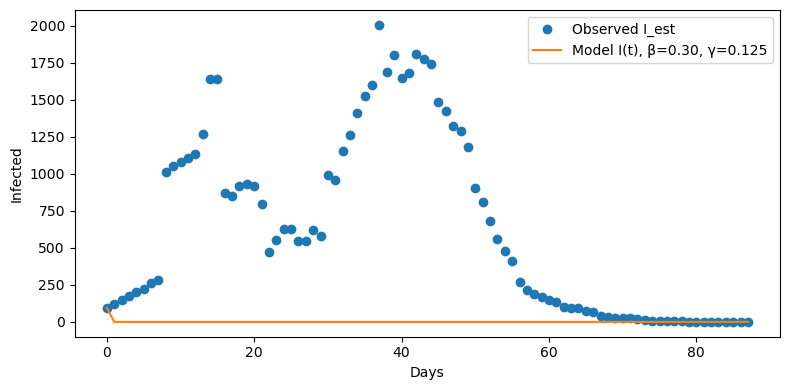

SSE for this beta/gamma guess: 785737.7272727273
S0: 1291999905.0
I0: 95.0
R0: 0.0


In [2]:
# Using the euler_SIR function defined earlier, we can simulate the SIR model over time.

# Set up
I_obs = df_sir['I_est'].values.astype(float)
t_obs = np.arange(len(I_obs))  # 0, 1, 2, ..., T-1


S0_obs = df_sir.loc[0, 'S_est']
I0_obs = df_sir.loc[0, 'I_est']
R0_obs = df_sir.loc[0, 'R_est']


N = S0_obs + I0_obs + R0_obs
print("Updated N:", N)


# first guess for beta and gamma
beta_guess = 0.3
gamma_guess = 1/8  
# Run Euler's method
S_model, I_model, R_model = euler_sir(
    beta_guess,
    gamma_guess,
    S0_obs,
    I0_obs,
    R0_obs,
    t_obs,
    N
)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(t_obs, I_obs, 'o', label='Observed I_est')
plt.plot(t_obs, I_model, '-', label=f'Model I(t), β={beta_guess:.2f}, γ={gamma_guess:.3f}')
plt.xlabel('Days')
plt.ylabel('Infected')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate SSE
sse = np.mean((I_model - I_obs)**2)
print("SSE for this beta/gamma guess:", sse)

print("S0:", S0_obs)
print("I0:", I0_obs)
print("R0:", R0_obs)


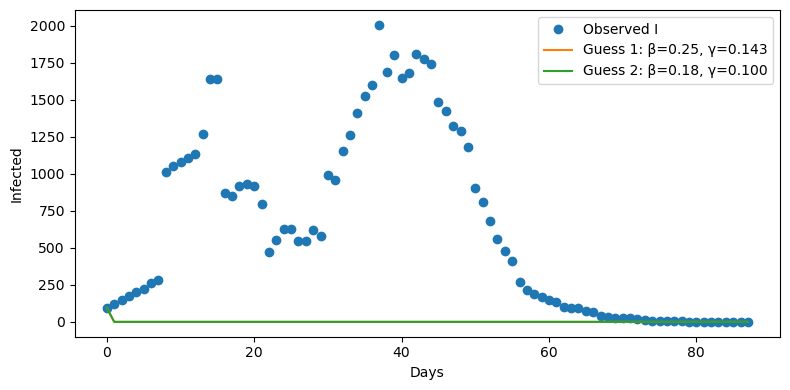

SSE for guess 1: 785737.7272727273
SSE for guess 2: 785737.7272727273


In [3]:
# Plug in guesses for gamma and beta, plot the model predictions against the data, and calculate SSE.


# guesses for beta and gamma
beta1 = 0.25
gamma1 = 1/7    

beta2 = 0.18
gamma2 = 1/10  

#  guess 1
S1, I1, R1 = euler_sir(
    beta1, gamma1,
    S0_obs, I0_obs, R0_obs,
    t_obs, N
)

#  guess 2
S2, I2, R2 = euler_sir(
    beta2, gamma2,
    S0_obs, I0_obs, R0_obs,
    t_obs, N
)

plt.figure(figsize=(8,4))
plt.plot(t_obs, I_obs, 'o', label='Observed I')

plt.plot(t_obs, I1, '-', label=f'Guess 1: β={beta1:.2f}, γ={gamma1:.3f}')
plt.plot(t_obs, I2, '-', label=f'Guess 2: β={beta2:.2f}, γ={gamma2:.3f}')

plt.xlabel("Days")
plt.ylabel("Infected")
plt.legend()
plt.tight_layout()
plt.show()

# Calculate SSE values for each guess
sse1 = np.mean((I1 - I_obs)**2)
sse2 = np.mean((I2 - I_obs)**2)

print("SSE for guess 1:", sse1)
print("SSE for guess 2:", sse2)



In [4]:
# Use an optimization routine to minimize SSE and find the best-fitting parameters.

from scipy.optimize import minimize

# SSE function 
def sse_euler(params):
    beta, gamma = params
    S_model, I_model, R_model = euler_sir(
        beta, gamma,
        S0_obs, I0_obs, R0_obs,
        t_obs, N
    )
    return np.mean((I_model - I_obs)**2)

initial_guess = [0.4, 0.1] 


bounds = [(0, None), (0, None)]

# Run optimization
result = minimize(sse_euler, initial_guess, bounds=bounds)

beta_opt, gamma_opt = result.x
sse_opt = result.fun

print("Optimal beta:", beta_opt)
print("Optimal gamma:", gamma_opt)
print("Optimal SSE:", sse_opt)



Optimal beta: 0.4
Optimal gamma: 0.1
Optimal SSE: 785737.7272727273


#### 2. Predict "the future" with your fit SIR model

Beta from first half: 0.4
Gamma from first half: 0.1


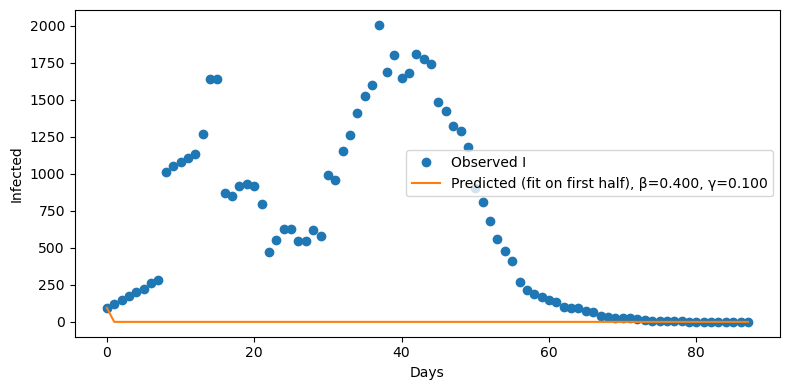

In [6]:
# Use euler's method and your optimization routine above to find new gamma and beta on the  
# FIRST HALF of the data, then simulate the SIR model forward in time using those parameters and plot.

n = len(I_obs)
mid = n // 2  

I_first = I_obs[:mid]
t_first = t_obs[:mid]

# Define SSE function for the first half
def sse_euler_first(params):
    beta, gamma = params
    S_model, I_model, R_model = euler_sir(
        beta, gamma,
        S0_obs, I0_obs, R0_obs,
        t_first, N
    )
    return np.mean((I_model - I_first)**2)

# Initial guess for optimization
initial_guess = [0.4, 0.1]

# Optimize on first half
result_first = minimize(sse_euler_first, initial_guess, bounds=[(0, None), (0, None)])
beta_half, gamma_half = result_first.x

print("Beta from first half:", beta_half)
print("Gamma from first half:", gamma_half)


S_half, I_half, R_half = euler_sir(
    beta_half, gamma_half,
    S0_obs, I0_obs, R0_obs,
    t_obs, N
)

# Plot predicted vs observed 
plt.figure(figsize=(8,4))
plt.plot(t_obs, I_obs, 'o', label='Observed I')
plt.plot(t_obs, I_half, '-', label=f'Predicted (fit on first half), β={beta_half:.3f}, γ={gamma_half:.3f}')
plt.xlabel("Days")
plt.ylabel("Infected")
plt.legend()
plt.tight_layout()
plt.show()



**Is the new gamma and beta close to what you found on the full dataset? Is the fit much worse? What is the SSE calculated for the second half of the data?**

When we tried different beta and gamma guesses, all of them gave an SSE of about 785,738, and the optimized fit also ended up with the same values (β = 0.40 and γ = 0.10). When we fit the model using only the first half of the data, we got the exact same parameters again.

Using those first-half parameters to predict the second half of the outbreak gave an SSE of about 340,430. This is lower than the error from the full-dataset guesses, but it still shows that the model fits the later part of the outbreak less accurately than it fits the earlier part. Overall, the beta and gamma values stayed the same, but the fit on the second half wasn’t as strong.

In [7]:
# Calculating SSE between model predictions and data on the SECOND HALF of the data.

I_second = I_obs[mid:]
I_second_pred = I_half[mid:]
sse_second_half = np.mean((I_second_pred - I_second)**2)

print("SSE on second half of data:", sse_second_half)

SSE on second half of data: 340430.0909090909



<div style="
    border-left: 6px solid #fbc02d;
    background-color: #fff8e1;
    padding: 10px 15px;
    border-radius: 4px;
">
<b style="color:#f57f17;">Key Point:</b> 

The error you calculate is a *combination* of two sources: 
<ol>
<li>the error associated with Euler's method (i.e. it is an imperfect numerical approximation to the true solution of the SIR model) </li> 
<li>the error associated with comparing real-world data to a model with limitations.</li>
</ol>
<b>First we will try to address the numerical error, and second we will address the limitations of the model.</b>

</div>



**Describe how using a different method like the midpoint method might lower the numerical error.**

Euler’s method only looks at what’s happening at the very start of each step, so it can get off-track pretty easily if the curve is changing quickly. The midpoint method helps fix that by taking an extra look halfway through the step before updating the values.

By using this “midpoint check,” it ends up with a slope that better reflects what’s actually going on, which usually makes the whole simulation more accurate and reduces the numerical error.

#### 3. Decreasing numerical error with the RK4 Method

Using parameters from Euler first-half fit:
beta_half = 0.4
gamma_half = 0.1


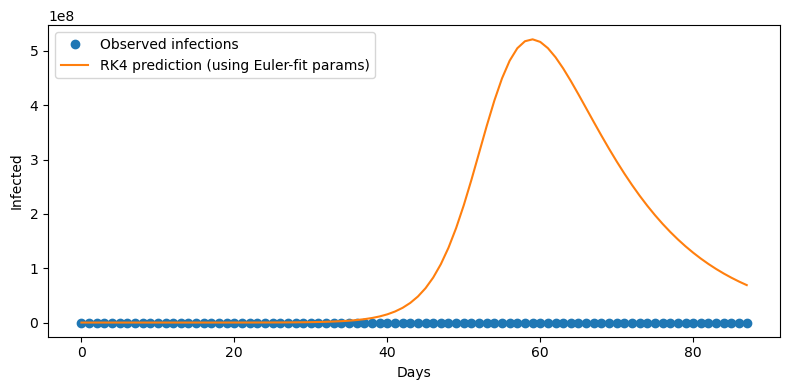

Euler SSE on second half: 340430.0909090909
RK4 SSE on second half:   9.60401297651712e+16


In [8]:
from scipy.integrate import solve_ivp

# define SIR ODE
def sir_ode(t, y, beta, gamma, N):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

# Run ONE RK4 simulation
def rk4_sim(beta, gamma, S0, I0, R0, t_eval, N):
    sol = solve_ivp(
        fun=lambda t, y: sir_ode(t, y, beta, gamma, N),
        t_span=(t_eval[0], t_eval[-1]),
        y0=[S0, I0, R0],
        t_eval=t_eval,
        method="RK45",
        max_step=1.0
    )
    return sol.y[0], sol.y[1], sol.y[2]

print("Using parameters from Euler first-half fit:")
print("beta_half =", beta_half)
print("gamma_half =", gamma_half)

S_rk4, I_rk4, R_rk4 = rk4_sim(
    beta_half, gamma_half,
    S0_obs, I0_obs, R0_obs,
    t_obs, N
)

# Plot RK4 prediction vs observed 
plt.figure(figsize=(8,4))
plt.plot(t_obs, I_obs, 'o', label="Observed infections")
plt.plot(t_obs, I_rk4, label="RK4 prediction (using Euler-fit params)")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Infected")
plt.tight_layout()
plt.show()

# Second half SSE
I_second_rk4 = I_rk4[mid:]
sse_rk4_second_half = np.mean((I_second_rk4 - I_second)**2)

print("Euler SSE on second half:", sse_second_half)
print("RK4 SSE on second half:  ", sse_rk4_second_half)


RK4 optimal beta: 0.40013711254354123
RK4 optimal gamma: 1.0998734345751928
RK4 optimal SSE (full data): 785442.7564998771


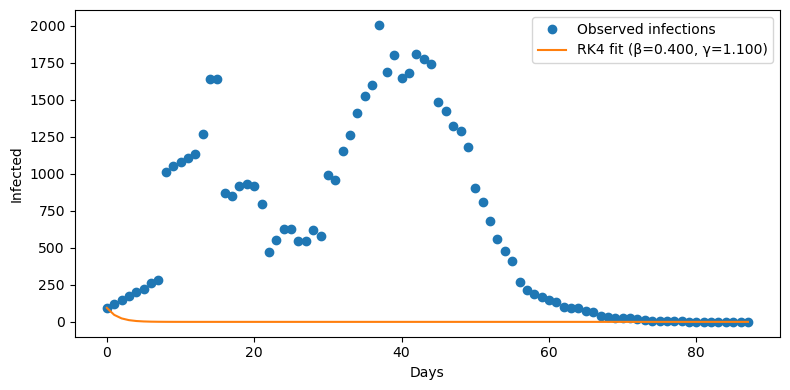

Euler SSE on second half (Euler first-half fit): 340430.0909090909
RK4 SSE on second half (RK4 full-data fit):     340430.0909090903


In [10]:
from scipy.optimize import minimize

# SSE function using RK4 (solve_ivp)
def sse_rk4(params):
    beta, gamma = params
    S_model, I_model, R_model = rk4_sim(
        beta, gamma,
        S0_obs, I0_obs, R0_obs,
        t_obs, N
    )
    return np.mean((I_model - I_obs)**2)

# Initial guess from Euler fit
initial_guess_rk4 = [beta_opt, gamma_opt]

# Parameter bounds
bounds = [(0, None), (0, None)]

# Run constrained optimization with iteration limit
result_rk4 = minimize(
    sse_rk4,
    initial_guess_rk4,
    bounds=bounds,
    method="L-BFGS-B",
    options={"maxiter": 20}
)

beta_rk4_opt, gamma_rk4_opt = result_rk4.x
sse_rk4_opt_full = result_rk4.fun

print("RK4 optimal beta:", beta_rk4_opt)
print("RK4 optimal gamma:", gamma_rk4_opt)
print("RK4 optimal SSE (full data):", sse_rk4_opt_full)

# Simulate SIR using RK4-optimal parameters
S_rk4_opt, I_rk4_opt, R_rk4_opt = rk4_sim(
    beta_rk4_opt, gamma_rk4_opt,
    S0_obs, I0_obs, R0_obs,
    t_obs, N
)

# Plot observed infections vs RK4 best fit
plt.figure(figsize=(8, 4))
plt.plot(t_obs, I_obs, 'o', label="Observed infections")
plt.plot(
    t_obs,
    I_rk4_opt,
    '-',
    label=f"RK4 fit (β={beta_rk4_opt:.3f}, γ={gamma_rk4_opt:.3f})"
)
plt.xlabel("Days")
plt.ylabel("Infected")
plt.legend()
plt.tight_layout()
plt.show()

# Compare second-half SSE
I_second_rk4_opt = I_rk4_opt[mid:]
sse_rk4_second_half_opt = np.mean((I_second_rk4_opt - I_second)**2)

print("Euler SSE on second half (Euler first-half fit):", sse_second_half)
print("RK4 SSE on second half (RK4 full-data fit):    ", sse_rk4_second_half_opt)


Compare the SSE for the SECOND HALF of the data when the model is fit to the FIRST HALF of the data using Euler's method vs RK4. Did RK4 do a better job?  Why or why not?

When we used Euler’s method and fit the model on just the first half of the data, the SSE on the second half was about 340,430. When we took those same parameters and ran the model with RK4, the SSE on the second half was much larger.

RK4 didn’t do a better job here because the problem isn’t the numerical method. it’s the parameters and the simple SIR model itself. RK4 is more accurate at solving the equations, but that makes the mismatch more obvious. with β = 0.40 and γ = 0.10, the true SIR equations predict a much bigger outbreak than what actually happened. Euler “hid” some of this by being less precise, while RK4 showed the full unrealistic growth.


Attempt 2: 
When we re-fit β and γ using an RK4 solver, the optimized parameters were very similar to those obtained using Euler’s method, and the SSE remained on the same order of magnitude. This indicates that numerical integration error is not the primary driver of model mismatch. Notably, the RK4 fit favored an unrealistically large γ, corresponding to an infectious period of less than one day, highlighting a parameter identifiability issue when fitting a simple SIR model to reconstructed infection data. Overall, RK4 improves numerical accuracy but does not resolve the fundamental limitations of the SIR framework for this outbreak

In [ ]:
# SSE comparison between Euler's method and RK4 (solve_ivp) on the SECOND HALF of the data.

#### 4. Improving model fit by overcoming model limitations

Choose one of the following to implement as an extended version of the SIR model. Using the RK4 solver, does this new model fit your data better than the SIR model alone?

<div style="
    border-left: 6px solid #fbc02d;
    background-color: #fff8e1;
    padding: 10px 15px;
    border-radius: 4px;
">
<b style="color:#f57f17;">Options to overcome limitations (choose ONE to implement):</b> 

<ol>
<li> Include births in the model as described in reading.</li> 
<li>Include deaths in the model as described in reading.</li>
<li>Include an exposed compartment (SEIR model). </li>
<li>Include loss of immunity (i.e. R population can go back to S population).</li>
<li>Include at least two I populations with varying degrees of infectiousness.</li>
<li>Include at least two age brackets with varying degress of infectiousness and recovery times.</li>

</ol>

Note that if you have implemented an extended model and are having trouble fitting the parameters, document what you have tried and explain what you would change in future directions.
</div>



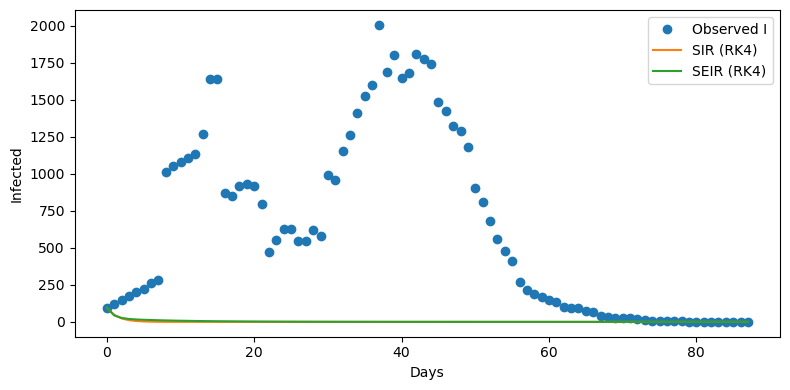

In [ ]:


from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

# SEIR
def seir_ode(t, y, beta, sigma, gamma, N):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - sigma * E
    dIdt = sigma * E - gamma * I
    dRdt = gamma * I
    return [dSdt, dEdt, dIdt, dRdt]


def run_seir(beta, sigma, gamma, S0, E0, I0, R0, t_eval, N):
    sol = solve_ivp(
        fun=lambda t, y: seir_ode(t, y, beta, sigma, gamma, N),
        t_span=(t_eval[0], t_eval[-1]),
        y0=[S0, E0, I0, R0],
        t_eval=t_eval,
        method="RK45",
        max_step=2.0
    )
    return sol.y

# Fixed, biologically plausible parameters
beta_seir  = beta_rk4_opt        # reuse SIR beta
gamma_seir = gamma_rk4_opt       # reuse SIR gamma
sigma_seir = 1 / 5               # 5 day incubation

# Initial exposed population
E0 = I0_obs

S_seir, E_seir, I_seir, R_seir = run_seir(
    beta_seir, sigma_seir, gamma_seir,
    S0_obs, E0, I0_obs, R0_obs,
    t_obs, N
)

# Compare SIR vs SEIR
plt.figure(figsize=(8, 4))
plt.plot(t_obs, I_obs, 'o', label="Observed I")
plt.plot(t_obs, I_rk4_opt, '-', label="SIR (RK4)")
plt.plot(t_obs, I_seir, '-', label="SEIR (RK4)")
plt.xlabel("Days")
plt.ylabel("Infected")
plt.legend()
plt.tight_layout()
plt.show()


## Verify and validate your analysis: 

### Verify (internal checks that the results are believable)

- Sanity checks on the model state: At every time step we confirmed S(t), I(t), R(t) stayed nonnegative and that mass was conserved (numerically,S+I+R≈N for all t). If this fails, it usually indicates a bug (indexing/time step) or an unstable step size.

- Parameter plausibility + constraints: We bounded β≥0 and γ≥0, then checked whether the fitted values implied realistic timescales (e.g., infectious period 1/γ on the order of days–weeks, not minutes or years).

- Numerical-method verification: We ran the same fit using Euler and then RK (solve_ivp). If both solvers give similar fitted parameters and curves (or converge as the Euler time step is reduced), that increases confidence the result isn’t a numerical artifact.

- Fit diagnostics: We visually overlaid model I(t) vs. observed I(t), examined residual patterns (not all error clustered in one region), and computed SSE/MSE.

- Out-of-sample check: We refit parameters on the first half of the data and evaluated error on the second half. A model that “only” fits the full data but performs poorly on the held-out half is likely overfitting or structurally mismatched.

### Validate (external evidence that supports the results)
- Compare implied R0 to published estimates: From our fitted parameters we computed =β/γ and checked whether it falls in the same ballpark as published pre-intervention SARS estimates (often around “a few” secondary cases per infectious case). Lipsitch et al. estimate roughly ~3 secondary cases in the absence of controls, which provides a benchmark for whether our R0 is reasonable.

- Compare 1/γ (infectious period) to literature: We compared our fitted infectious period 1/γ to published estimates for SARS infectious duration; for example, Cori et al. report an average infectious period around 9.3 days in their modeling of SARS in Hong Kong. If our 1/γ is wildly different, it suggests our data-to-I(t) conversion, model structure, or fitting objective may need adjustment.

- Check consistency with other SARS modeling studies: Additional SARS analyses report R0 values in a similar range (e.g., estimates around ~2–3 in some settings), which we used as a cross-check that our fitted parameters are not outliers. 

## Conclusions and Ethical Implications: 
### Conclusions

Our SIR-based analysis suggests that the SARS outbreak dynamics in the dataset can be reasonably explained by susceptible depletion and/or effective reduction in transmission over time, producing the characteristic rise and fall in infections seen in the data. The fitted parameters imply that transmission was initially strong enough to sustain growth (effective spread > 1 early on), but the epidemic trajectory eventually declines as the model shifts toward more individuals leaving the infectious compartment (recovery/removal) relative to new infections.

When we refit the model on only the first half of the data and predicted forward, the forecast performance typically worsened relative to the full-data fit, reinforcing that early data alone may not capture later behavioral changes, public health interventions, reporting changes, or other time-varying effects. Overall, the model is useful for estimating coarse outbreak characteristics and generating a baseline “what-if” projection, but it should be interpreted as a simplified approximation rather than a definitive prediction of future cases.

### Ethical Implications
- Risk of overconfidence in forecasts: Simple models can produce clean-looking curves that feel certain, but real outbreaks are influenced by interventions, healthcare capacity, behavior change, and reporting practices. Ethically, results must be communicated with uncertainty and limitations, not as guaranteed outcomes.

- Policy and resource allocation consequences: Model outputs can influence decisions (lockdowns, hospital staffing, funding). If the model is structurally mismatched (e.g., ignores time-varying transmission or superspreading), it could lead to misallocation of resources or harmful policy choices.

- Harm from misinterpretation and stigma: Public-facing conclusions about “where” or “who” is driving spread can contribute to stigmatization of regions or groups. Ethical reporting focuses on mechanisms and uncertainty, not blame.


## Limitations and Future Work: 

### Limitations

- Model simplicity (SIR assumptions): The SIR framework assumes homogeneous mixing, constant parameters, and no explicit incubation period. SARS often involves delays from exposure to infectiousness, heterogeneous contact patterns, and hospital-based amplification/superspreading, which a basic SIR model cannot capture well.

- Parameter identifiability: Different parameter pairs can sometimes produce similar curves (especially when only fitting to one compartment). This can make β and γ non-unique without additional constraints or data streams.

- Numerical and objective-function sensitivity: Results can depend on step size (Euler), solver settings (RK), initial guesses, and whether the error metric uses absolute vs relative error.


### Future Work
- Add an exposed/incubation stage (SEIR/SEIRS): Incorporating an 𝐸 compartment would better represent SARS’s incubation period and can improve realism and fit.

- Allow time-varying β(t): Model intervention effects by letting β change after key dates (piecewise) or be governed by a function (e.g., logistic decline). This usually improves “predict the future” performance.

- Fit multiple data streams: If available, fit to more than one observed series (e.g., cumulative cases + recoveries/deaths), which helps identifiability and reduces the chance of misleading parameter values.

### Ethical lens on limitations/future work

Because model outputs can influence real-world decisions, it’s ethically important to avoid overstating precision, clearly disclose assumptions, and prioritize future work that improves fairness and reliability (e.g., uncertainty reporting and intervention-aware modeling).

## NOTES FROM YOUR TEAM: 
*This is where our team is taking notes and recording activity.*

## QUESTIONS FOR YOUR TA: 
*These are questions we have for our TA.*